# Network Hardening con Automated Planning

Sistema di pianificazione automatica per la messa in sicurezza di infrastrutture di rete.

**Obiettivo:** Chiudere tutte le porte di rete considerate insicure, minimizzando il costo operativo e garantendo la continuità dei servizi critici.

---

## Indice

1. [Setup e Installazione](#1-setup)
2. [Configurazione del Dominio](#2-configurazione)
3. [Modello di Planning](#3-modello)
4. [Generazione Scenari](#4-scenari)
5. [Esecuzione e Risultati](#5-esecuzione)
6. [Analisi dei Risultati](#6-analisi)

---
## 1. Setup e Installazione <a id="1-setup"></a>

Installazione delle librerie necessarie per il planning automatico.

In [1]:
# Installazione librerie:
# - unified-planning: framework per modellare problemi di planning
# - up-fast-downward: solver (motore di ricerca) per trovare i piani
# - pandas: manipolazione dati tabulari
# - matplotlib: creazione grafici
!pip install -q unified-planning up-fast-downward pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 713.3/713.3 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 8.6 MB/s eta 0:00:00


In [2]:
import json              # Per leggere/scrivere file JSON (scenari)
import os                # Per operazioni su file e directory
import time              # Per misurare i tempi di esecuzione
import warnings          # Per silenziare warning non rilevanti
import pandas as pd      # Per creare tabelle di risultati
import matplotlib.pyplot as plt  # Per creare grafici

# Import dal framework Unified Planning
from unified_planning.shortcuts import *  # Importa tutte le classi principali (Problem, Fluent, Action, etc.)
from unified_planning.engines import PlanGenerationResultStatus  # Per verificare se il piano è stato trovato

# Configurazione ambiente
warnings.filterwarnings('ignore')  # Nasconde warning del solver (verbosi ma non utili)
os.makedirs('scenarios', exist_ok=True)  # Crea cartella per gli scenari JSON
os.makedirs('results', exist_ok=True)    # Crea cartella per i risultati

print("Librerie caricate correttamente.")

Librerie caricate correttamente.


---
## 2. Configurazione del Dominio <a id="2-configurazione"></a>

### 2.1 Mapping Servizi e Porte

Ogni servizio di rete utilizza una porta specifica. Questo mapping definisce le associazioni standard.

**Esempio:** Il servizio `http` usa la porta `80`, il servizio `mysql` usa la porta `3306`.

In [3]:
# === MAPPING SERVIZIO -> PORTE ===
# Dizionario che associa ogni servizio alla lista delle sue porte
# Nota: alcuni servizi potrebbero usare più porte, quindi il valore è una lista

SERVICE_PORT_MAPPING = {
    # Servizi web
    'http': [80],           # HTTP non cifrato (insicuro)
    'https': [443],         # HTTP cifrato (sicuro)
    'ssh': [22],            # Secure Shell (sicuro)

    # Database
    'mysql': [3306],        # MySQL
    'postgresql': [5432],   # PostgreSQL
    'redis': [6379],        # Redis (cache)
    'mongodb': [27017],     # MongoDB

    # Protocolli legacy (generalmente insicuri)
    'ftp': [21],            # File Transfer Protocol
    'telnet': [23],         # Terminale remoto non cifrato
    'smtp': [25],           # Email (versione base)
    'pop3': [110],          # Email retrieval
    'imap': [143],          # Email retrieval

    # Application server
    'tomcat': [8080],       # Java application server
    'nodejs': [3000],       # Node.js default port
    'rabbitmq': [5672],     # Message queue

    # Monitoring
    'prometheus': [9090],   # Metrics collection
    'grafana': [3000],      # Dashboard
    'elasticsearch': [9200], # Search engine
    'kibana': [5601],       # Log visualization

    # File sharing e accesso remoto
    'smb': [445],           # Windows file sharing
    'netbios': [139],       # Legacy Windows networking
    'rdp': [3389],          # Remote Desktop
    'vnc': [5900],          # Virtual Network Computing
    'nfs': [2049],          # Network File System
    'ldap': [389],          # Directory service

    # Utility
    'rsync': [873],         # File synchronization
    'snmp': [161],          # Network management (insicuro)
    'tftp': [69],           # Trivial FTP (molto insicuro)
}

### 2.2 Porte Alternative per la Migrazione

Alcune porte insicure possono essere migrate su alternative più sicure. Le porte senza alternativa (es. NetBIOS, SMTP, SNMP, TFTP) richiedono la disattivazione del servizio.

**Scelta progettuale:** Non tutte le porte hanno un'alternativa. Questo forza il planner a utilizzare strategie diverse in base al contesto.

In [4]:
# === PORTE ALTERNATIVE PER MIGRAZIONE ===
# Quando una porta è vietata, il servizio può essere migrato su una porta alternativa
# Formato: porta_originale -> porta_alternativa

ALTERNATIVE_PORTS = {
    80: 8080,      # HTTP: da 80 a 8080
    21: 2121,      # FTP: da 21 a 2121
    23: 2323,      # Telnet: da 23 a 2323
    110: 1110,     # POP3: da 110 a 1110
    143: 1143,     # IMAP: da 143 a 1143
    3389: 33389,   # RDP: da 3389 a 33389
    5900: 59000,   # VNC: da 5900 a 59000
    445: 4455,     # SMB: da 445 a 4455
    389: 3890,     # LDAP: da 389 a 3890
    2049: 20490,   # NFS: da 2049 a 20490

    # NOTA: Le seguenti porte NON hanno alternativa!
    # Questo significa che i servizi su queste porte devono essere DISATTIVATI
    # - 25 (SMTP): protocollo email legacy
    # - 139 (NetBIOS): protocollo Windows obsoleto
    # - 161 (SNMP): management non sicuro
    # - 69 (TFTP): trasferimento file senza autenticazione
}

# === COSTI DELLE AZIONI ===
# Il planner cercherà di minimizzare il costo totale del piano
# Costi più alti = azioni meno desiderabili

ACTION_COSTS = {
    'chiudi_porta': 1,       # Costo basso: operazione semplice, nessun impatto
    'disattiva_servizio': 5, # Costo alto: causa downtime del servizio!
    'migra_servizio': 3      # Costo medio: richiede riconfigurazione ma no downtime
}

---
## 3. Modello di Planning <a id="3-modello"></a>

### 3.1 Definizione del Dominio

Il dominio definisce:
- **Tipi**: le categorie di oggetti (Host, Port, Service)
- **Fluent**: predicati che descrivono lo stato del mondo (es. "la porta 80 è aperta")

| Fluent | Tipo | Descrizione |
|--------|------|-------------|
| `porta_aperta(host, port)` | Bool | Indica se una porta è aperta |
| `servizio_attivo(host, service)` | Bool | Indica se un servizio è in esecuzione |
| `servizio_critico(host, service)` | Bool | Servizi che non possono essere fermati |
| `servizio_usa_porta(host, service, port)` | Bool | Relazione servizio-porta |
| `dipende_da(host, srv_dip, srv_base)` | Bool | Dipendenze tra servizi |

In [5]:
class NetworkHardeningDomain:
    """
    Definisce il DOMINIO di planning per il network hardening.

    Un dominio specifica:
    - I TIPI di oggetti che esistono nel mondo
    - I FLUENT (predicati) che descrivono lo stato
    """

    def __init__(self):
        # Crea un nuovo problema di planning
        self.problem = Problem('network_hardening')

        # === DEFINIZIONE DEI TIPI ===
        # I tipi definiscono le "categorie" di oggetti nel nostro mondo
        Host = UserType('Host')       # Un server o macchina nella rete
        Port = UserType('Port')       # Una porta di rete (es. 80, 443, 22)
        Service = UserType('Service') # Un servizio software (es. http, mysql)

        # === DEFINIZIONE DEI FLUENT ===
        # I fluent sono "variabili" che descrivono lo stato del mondo
        # Sono tutti booleani: vero o falso

        self.fluents = {
            # porta_aperta(host, port) = True se la porta è aperta sull'host
            'porta_aperta': Fluent('porta_aperta', BoolType(), host=Host, port=Port),

            # servizio_attivo(host, service) = True se il servizio è in esecuzione
            'servizio_attivo': Fluent('servizio_attivo', BoolType(), host=Host, service=Service),

            # servizio_critico(host, service) = True se il servizio NON può essere fermato
            'servizio_critico': Fluent('servizio_critico', BoolType(), host=Host, service=Service),

            # servizio_usa_porta(host, service, port) = True se il servizio usa quella porta
            'servizio_usa_porta': Fluent('servizio_usa_porta', BoolType(),
                                         host=Host, service=Service, port=Port),

            # dipende_da(host, srv_A, srv_B) = True se srv_A dipende da srv_B
            # Esempio: se 'http' dipende da 'mysql', non posso fermare mysql prima di http
            'dipende_da': Fluent('dipende_da', BoolType(),
                                host=Host, service_dipendente=Service, service_base=Service)
        }

        # Aggiungi tutti i fluent al problema
        # default_initial_value=False significa che di default tutto è "falso"
        # (le porte sono chiuse, i servizi sono inattivi, etc.)
        for fluent in self.fluents.values():
            self.problem.add_fluent(fluent, default_initial_value=False)

        # Salva i tipi per uso successivo
        self.types = {'Host': Host, 'Port': Port, 'Service': Service}

### 3.2 Azioni Disponibili

Il sistema utilizza 3 azioni:

| Azione | Costo | Precondizioni | Effetti |
|--------|-------|---------------|--------|
| `chiudi_porta` | 1 | Porta aperta, nessun servizio attivo | Porta chiusa |
| `disattiva_servizio` | 5 | Servizio attivo, non critico, nessun dipendente attivo | Servizio inattivo |
| `migra_servizio` | 3 | Servizio attivo, porta alternativa chiusa | Servizio su nuova porta |

In [6]:
# === FUNZIONI DI UTILITÀ ===

def get_services_on_port(host_data, port, mapping):
    """
    Trova quali servizi usano una specifica porta su un host.

    Esempio: get_services_on_port(webserver, 80, mapping) -> ['http']

    Args:
        host_data: dizionario con i dati dell'host (inclusa lista 'services')
        port: numero della porta da cercare
        mapping: dizionario SERVICE_PORT_MAPPING

    Returns:
        Lista dei servizi che usano quella porta
    """
    result = []
    # Per ogni servizio attivo sull'host...
    for service in host_data.get('services', []):
        # ...controlla se usa la porta cercata
        if port in mapping.get(service, []):
            result.append(service)
    return result


def get_dependent_services(host_id, service, dependencies):
    """
    Trova quali servizi DIPENDONO dal servizio specificato.

    Se A dipende da B, allora A è un "dependente" di B.
    Non posso fermare B finché A è attivo!

    Esempio: se http dipende da mysql, get_dependent_services(host, 'mysql', deps) -> ['http']

    Args:
        host_id: ID dell'host
        service: servizio di cui cercare i dipendenti
        dependencies: dizionario delle dipendenze

    Returns:
        Lista dei servizi che dipendono da 'service'
    """
    # Ottieni le dipendenze per questo host
    host_deps = dependencies.get(host_id, {})

    dependents = []
    # Per ogni servizio e le sue dipendenze...
    for srv, deps_list in host_deps.items():
        # ...se dipende dal servizio cercato, aggiungilo
        if service in deps_list:
            dependents.append(srv)

    return dependents

### 3.3 Setup del Problema

Questa è la funzione principale che costruisce il problema di planning completo a partire da uno scenario JSON.

Il processo è:
1. **Creare gli oggetti** (host, porte, servizi)
2. **Impostare lo stato iniziale** (quali porte sono aperte, quali servizi attivi)
3. **Generare le azioni** possibili
4. **Definire i goal** (quali porte devono essere chiuse)

In [7]:
def setup_problem(scenario):
    """
    Costruisce il problema di planning completo a partire da uno scenario.

    Args:
        scenario: dizionario con la configurazione dello scenario

    Returns:
        problem: il problema di planning pronto per essere risolto
        domain: il dominio (per accesso ai fluent)
        objects: dizionario degli oggetti creati
    """

    # === FASE 0: INIZIALIZZAZIONE ===
    domain = NetworkHardeningDomain()  # Crea il dominio
    problem = domain.problem            # Riferimento al problema
    objects = {}                        # Dizionario per memorizzare gli oggetti creati

    # Estrai le configurazioni dallo scenario
    forbidden = scenario['policy']['forbidden_ports']           # Porte da chiudere
    critical = scenario['policy'].get('critical_services', {})  # Servizi critici
    mapping = scenario.get('service_port_mapping', SERVICE_PORT_MAPPING)  # Mapping servizi-porte
    dependencies = scenario.get('service_dependencies', {})     # Dipendenze tra servizi

    # =========================================================
    # FASE 1: CREAZIONE OGGETTI
    # =========================================================

    # --- Crea oggetti HOST ---
    for h in scenario['hosts']:
        host_id = h['id']  # es. 'webserver', 'database'
        objects[host_id] = Object(host_id, domain.types['Host'])
        problem.add_object(objects[host_id])

    # --- Crea oggetti PORT ---
    # Raccogli tutte le porte: quelle aperte + le alternative per migrazione
    all_ports = set()
    for h in scenario['hosts']:
        all_ports.update(h['open_ports'])  # Aggiungi porte aperte
    for p in forbidden:
        if p in ALTERNATIVE_PORTS:
            all_ports.add(ALTERNATIVE_PORTS[p])  # Aggiungi porte alternative

    for p in sorted(all_ports):
        port_key = f'port_{p}'  # es. 'port_80', 'port_443'
        objects[port_key] = Object(port_key, domain.types['Port'])
        problem.add_object(objects[port_key])

    # --- Crea oggetti SERVICE ---
    all_services = set()
    for h in scenario['hosts']:
        all_services.update(h.get('services', []))

    for s in sorted(all_services):
        srv_key = f'srv_{s}'  # es. 'srv_http', 'srv_mysql'
        objects[srv_key] = Object(srv_key, domain.types['Service'])
        problem.add_object(objects[srv_key])

    # =========================================================
    # FASE 2: STATO INIZIALE
    # =========================================================

    for h in scenario['hosts']:
        host_obj = objects[h['id']]

        # --- Imposta porte aperte ---
        for p in h['open_ports']:
            port_key = f'port_{p}'
            if port_key in objects:
                # porta_aperta(webserver, port_80) = True
                problem.set_initial_value(
                    domain.fluents['porta_aperta'](host_obj, objects[port_key]),
                    True
                )

        # --- Imposta servizi attivi e relazioni servizio-porta ---
        for s in h.get('services', []):
            srv_key = f'srv_{s}'
            if srv_key not in objects:
                continue  # Salta se il servizio non esiste

            srv_obj = objects[srv_key]

            # servizio_attivo(webserver, srv_http) = True
            problem.set_initial_value(
                domain.fluents['servizio_attivo'](host_obj, srv_obj),
                True
            )

            # Imposta relazione servizio-porta
            for p in mapping.get(s, []):
                if p in h['open_ports'] and f'port_{p}' in objects:
                    # servizio_usa_porta(webserver, srv_http, port_80) = True
                    problem.set_initial_value(
                        domain.fluents['servizio_usa_porta'](host_obj, srv_obj, objects[f'port_{p}']),
                        True
                    )

    # --- Imposta servizi critici ---
    for host_id, services in critical.items():
        if host_id in objects:
            for s in services:
                if f'srv_{s}' in objects:
                    # servizio_critico(database, srv_mysql) = True
                    problem.set_initial_value(
                        domain.fluents['servizio_critico'](objects[host_id], objects[f'srv_{s}']),
                        True
                    )

    # --- Imposta dipendenze tra servizi ---
    for host_id, deps_map in dependencies.items():
        if host_id not in objects:
            continue
        for s, deps in deps_map.items():
            if f'srv_{s}' not in objects:
                continue
            for base in deps:
                if f'srv_{base}' in objects:
                    # dipende_da(frontend, srv_http, srv_tomcat) = True
                    # significa: http dipende da tomcat
                    problem.set_initial_value(
                        domain.fluents['dipende_da'](
                            objects[host_id],
                            objects[f'srv_{s}'],
                            objects[f'srv_{base}']
                        ),
                        True
                    )

    # =========================================================
    # FASE 3: GENERAZIONE AZIONI
    # =========================================================
    # Le azioni sono "grounded", cioè istanziate per ogni combinazione valida di oggetti

    for h in scenario['hosts']:
        host_obj = objects[h['id']]

        # --- AZIONE: disattiva_servizio ---
        # Ferma un servizio (causa downtime!)
        for s in h.get('services', []):
            srv_key = f'srv_{s}'
            if srv_key not in objects:
                continue
            srv_obj = objects[srv_key]

            # Trova servizi che dipendono da questo
            dependents = get_dependent_services(h['id'], s, dependencies)

            # Crea l'azione
            action = InstantaneousAction(f"disattiva_servizio_{h['id']}_{s}")

            # PRECONDIZIONI:
            # 1. Il servizio deve essere attivo
            action.add_precondition(domain.fluents['servizio_attivo'](host_obj, srv_obj))
            # 2. Il servizio NON deve essere critico
            action.add_precondition(Not(domain.fluents['servizio_critico'](host_obj, srv_obj)))
            # 3. Nessun servizio dipendente deve essere attivo
            for dep in dependents:
                if f'srv_{dep}' in objects:
                    action.add_precondition(
                        Not(domain.fluents['servizio_attivo'](host_obj, objects[f'srv_{dep}']))
                    )

            # EFFETTO: il servizio diventa inattivo
            action.add_effect(domain.fluents['servizio_attivo'](host_obj, srv_obj), False)

            problem.add_action(action)

        # --- AZIONE: chiudi_porta ---
        # Chiude una porta (solo se nessun servizio la sta usando)
        for p in forbidden:
            if p not in h['open_ports']:
                continue  # La porta non è aperta su questo host

            port_obj = objects[f'port_{p}']
            services_on_port = get_services_on_port(h, p, mapping)

            action = InstantaneousAction(f"chiudi_porta_{h['id']}_p{p}")

            # PRECONDIZIONI:
            # 1. La porta deve essere aperta
            action.add_precondition(domain.fluents['porta_aperta'](host_obj, port_obj))
            # 2. Nessun servizio attivo deve usare la porta
            for s in services_on_port:
                if f'srv_{s}' in objects:
                    action.add_precondition(
                        Not(domain.fluents['servizio_attivo'](host_obj, objects[f'srv_{s}']))
                    )

            # EFFETTI:
            # 1. La porta viene chiusa
            action.add_effect(domain.fluents['porta_aperta'](host_obj, port_obj), False)
            # 2. Le relazioni servizio-porta vengono rimosse
            for s in services_on_port:
                if f'srv_{s}' in objects:
                    action.add_effect(
                        domain.fluents['servizio_usa_porta'](host_obj, objects[f'srv_{s}'], port_obj),
                        False
                    )

            problem.add_action(action)

        # --- AZIONE: migra_servizio ---
        # Sposta un servizio su una porta alternativa (no downtime!)
        for p in forbidden:
            # Verifica condizioni per la migrazione
            if p not in h['open_ports']:       # Porta non aperta
                continue
            if p not in ALTERNATIVE_PORTS:     # Nessuna alternativa disponibile
                continue

            new_p = ALTERNATIVE_PORTS[p]       # Porta alternativa

            if new_p in forbidden:             # Anche l'alternativa è vietata!
                continue
            if f'port_{new_p}' not in objects: # Porta alternativa non nel modello
                continue

            port_obj = objects[f'port_{p}']
            new_port_obj = objects[f'port_{new_p}']

            # Crea un'azione per ogni servizio che usa la porta
            for s in get_services_on_port(h, p, mapping):
                if f'srv_{s}' not in objects:
                    continue
                srv_obj = objects[f'srv_{s}']

                action = InstantaneousAction(f"migra_servizio_{h['id']}_{s}_p{p}to{new_p}")

                # PRECONDIZIONI:
                # 1. Servizio attivo
                action.add_precondition(domain.fluents['servizio_attivo'](host_obj, srv_obj))
                # 2. Porta originale aperta
                action.add_precondition(domain.fluents['porta_aperta'](host_obj, port_obj))
                # 3. Porta nuova CHIUSA (non occupata)
                action.add_precondition(Not(domain.fluents['porta_aperta'](host_obj, new_port_obj)))
                # 4. Servizio usa la porta originale
                action.add_precondition(
                    domain.fluents['servizio_usa_porta'](host_obj, srv_obj, port_obj)
                )

                # EFFETTI:
                # 1. Porta originale viene chiusa
                action.add_effect(domain.fluents['porta_aperta'](host_obj, port_obj), False)
                # 2. Porta nuova viene aperta
                action.add_effect(domain.fluents['porta_aperta'](host_obj, new_port_obj), True)
                # 3. Relazione con porta originale rimossa
                action.add_effect(
                    domain.fluents['servizio_usa_porta'](host_obj, srv_obj, port_obj),
                    False
                )
                # 4. Relazione con nuova porta aggiunta
                action.add_effect(
                    domain.fluents['servizio_usa_porta'](host_obj, srv_obj, new_port_obj),
                    True
                )
                # NOTA: il servizio resta attivo! Nessun downtime.

                problem.add_action(action)

    # =========================================================
    # FASE 4: DEFINIZIONE GOAL
    # =========================================================
    # Il goal è: tutte le porte vietate devono essere chiuse

    for h in scenario['hosts']:
        for p in forbidden:
            if p in h['open_ports'] and f'port_{p}' in objects:
                # Goal: NOT porta_aperta(host, port)
                problem.add_goal(
                    Not(domain.fluents['porta_aperta'](objects[h['id']], objects[f'port_{p}']))
                )

    # =========================================================
    # FASE 5: METRICA DI OTTIMIZZAZIONE
    # =========================================================
    # Il planner cercherà di minimizzare il costo totale delle azioni

    cost_map = {}  # Mappa azione -> costo

    for action in problem.actions:
        name = action.name.lower()
        # Assegna il costo in base al tipo di azione
        if 'chiudi_porta' in name:
            cost_map[action] = ACTION_COSTS['chiudi_porta']
        elif 'disattiva_servizio' in name:
            cost_map[action] = ACTION_COSTS['disattiva_servizio']
        elif 'migra_servizio' in name:
            cost_map[action] = ACTION_COSTS['migra_servizio']

    # Aggiungi la metrica: minimizza la somma dei costi
    if cost_map:
        problem.add_quality_metric(MinimizeActionCosts(cost_map))

    return problem, domain, objects

---
## 4. Generazione Scenari <a id="4-scenari"></a>

Gli scenari sono progettati per testare tutte le azioni del planner:
- **migra_servizio**: porte con alternativa disponibile (es. 80 → 8080)
- **disattiva_servizio**: porte senza alternativa (es. 139 NetBIOS)
- **chiudi_porta**: porte aperte senza servizi attivi (es. porta 23 su host senza telnet)

In [8]:
# === DEFINIZIONE SCENARI DI TEST ===
# Ogni scenario rappresenta una configurazione di rete diversa
# Formato host: (id, [porte_aperte], [servizi], is_critical_host)

SCENARIOS = [
    # ----- SCENARIO 1: Base con tutte le azioni -----
    {
        'name': '01_all_actions_basic',
        'description': 'Scenario base che richiede tutte e 3 le azioni',
        'hosts': [
            # web1: HTTP su porta 80 -> verrà MIGRATO su 8080
            ('web1', [80, 443, 22], ['http', 'https', 'ssh'], False),
            # fileserver: NetBIOS su 139 (no alternativa) -> verrà DISATTIVATO
            ('fileserver', [139, 445, 22], ['netbios', 'smb', 'ssh'], False),
            # legacy: porta 23 aperta ma SENZA telnet -> verrà CHIUSA direttamente
            ('legacy', [23, 22], ['ssh'], False),
        ],
        'forbidden': [80, 139, 23],  # Porte da chiudere
        'critical': {},               # Nessun servizio critico
        'dependencies': {},           # Nessuna dipendenza
    },

    # ----- SCENARIO 2: Con dipendenze tra servizi -----
    {
        'name': '02_deps_all_actions',
        'description': 'Dipendenze tra servizi: http -> tomcat -> mysql',
        'hosts': [
            ('frontend', [80, 443, 22], ['http', 'https', 'ssh'], False),
            ('backend', [8080, 22], ['tomcat', 'ssh'], False),
            ('mailserver', [25, 22], ['smtp', 'ssh'], False),  # SMTP no alternativa
            ('database', [3306, 22, 23], ['mysql', 'ssh'], True),  # MySQL è critico
        ],
        'forbidden': [80, 25, 23],
        'critical': {'database': ['mysql']},  # MySQL non può essere fermato
        'dependencies': {
            'frontend': {'http': ['tomcat']},    # http dipende da tomcat
            'backend': {'tomcat': ['mysql']}     # tomcat dipende da mysql
        },
    },

    # ----- SCENARIO 3: Infrastruttura enterprise -----
    {
        'name': '03_enterprise_mixed',
        'description': 'Infrastruttura enterprise con cluster web/app/db',
        'hosts': [
            ('web1', [80, 443, 22], ['http', 'https', 'ssh'], False),
            ('web2', [80, 443, 22], ['http', 'https', 'ssh'], False),
            ('app1', [8080, 21, 161, 22], ['tomcat', 'ftp', 'snmp', 'ssh'], False),
            ('app2', [8080, 21, 22], ['tomcat', 'ftp', 'ssh'], False),
            ('db_master', [3306, 22, 23], ['mysql', 'ssh'], True),
            ('db_slave', [3306, 22, 139], ['mysql', 'ssh'], True),
            ('storage', [445, 139, 22], ['smb', 'netbios', 'ssh'], False),
            ('monitoring', [9090, 22, 23], ['prometheus', 'ssh'], False),
        ],
        'forbidden': [80, 21, 23, 139, 161],
        'critical': {'db_master': ['mysql'], 'db_slave': ['mysql']},
        'dependencies': {
            'web1': {'http': ['tomcat']},
            'web2': {'http': ['tomcat']},
            'app1': {'tomcat': ['mysql']},
            'app2': {'tomcat': ['mysql']},
        },
    },

    # ----- SCENARIO 4: Post-breach security incident -----
    {
        'name': '04_security_incident',
        'description': 'Hardening post-incidente: chiusura massiva porte insicure',
        'hosts': [
            ('dmz_web', [80, 443, 22], ['http', 'https', 'ssh'], False),
            ('dmz_mail', [25, 110, 143, 22], ['smtp', 'pop3', 'imap', 'ssh'], False),
            ('internal_app', [8080, 3389, 22], ['tomcat', 'rdp', 'ssh'], False),
            ('admin_jump', [5900, 69, 22], ['vnc', 'tftp', 'ssh'], False),
            ('legacy_server', [23, 139, 22], ['ssh'], False),  # Porte aperte senza servizi!
            ('db_primary', [3306, 22], ['mysql', 'ssh'], True),
        ],
        'forbidden': [80, 25, 23, 139, 3389, 5900, 69],
        'critical': {'db_primary': ['mysql']},
        'dependencies': {
            'dmz_web': {'http': ['tomcat']},
            'internal_app': {'tomcat': ['mysql']},
        },
    },

    # ----- SCENARIO 5: Healthcare GDPR compliance -----
    {
        'name': '05_healthcare_gdpr',
        'description': 'Compliance GDPR/HIPAA: protezione dati sanitari',
        'hosts': [
            ('patient_portal', [80, 443, 22], ['http', 'https', 'ssh'], False),
            ('ehr_app', [8080, 443, 22], ['tomcat', 'https', 'ssh'], True),
            ('legacy_gateway', [25, 23, 22], ['smtp', 'ssh'], False),
            ('patient_db', [5432, 22], ['postgresql', 'ssh'], True),
            ('medical_files', [445, 139, 22], ['smb', 'netbios', 'ssh'], False),
            ('admin_ws', [3389, 161, 22], ['rdp', 'snmp', 'ssh'], False),
            ('audit_db', [3306, 22, 139], ['mysql', 'ssh'], True),
        ],
        'forbidden': [80, 25, 23, 139, 161, 3389],
        'critical': {
            'ehr_app': ['tomcat', 'https'],
            'patient_db': ['postgresql'],
            'audit_db': ['mysql']
        },
        'dependencies': {
            'patient_portal': {'http': ['tomcat']},
            'ehr_app': {'tomcat': ['postgresql']},
        },
    },

    # ----- SCENARIO 6: Financial PCI-DSS compliance -----
    {
        'name': '06_financial_pci',
        'description': 'Compliance PCI-DSS: ambiente bancario',
        'hosts': [
            ('web_banking', [80, 443, 22], ['http', 'https', 'ssh'], False),
            ('api_gateway', [443, 3000, 22], ['https', 'nodejs', 'ssh'], False),
            ('core_banking', [8080, 69, 22], ['tomcat', 'tftp', 'ssh'], True),
            ('tx_processor', [8080, 443, 22], ['tomcat', 'https', 'ssh'], True),
            ('mq_cluster', [5672, 161, 22], ['rabbitmq', 'snmp', 'ssh'], False),
            ('accounts_db', [5432, 22, 23], ['postgresql', 'ssh'], True),
            ('tx_db', [5432, 22, 139], ['postgresql', 'ssh'], True),
            ('admin_console', [3389, 5900, 22], ['rdp', 'vnc', 'ssh'], False),
            ('security_siem', [9200, 5601, 22, 23], ['elasticsearch', 'kibana', 'ssh'], False),
        ],
        'forbidden': [80, 23, 139, 161, 69, 3389, 5900],
        'critical': {
            'core_banking': ['tomcat'],
            'tx_processor': ['tomcat', 'https'],
            'accounts_db': ['postgresql'],
            'tx_db': ['postgresql']
        },
        'dependencies': {
            'web_banking': {'http': ['nodejs']},
            'api_gateway': {'nodejs': ['tomcat', 'rabbitmq']},
            'tx_processor': {'tomcat': ['postgresql', 'rabbitmq']},
        },
    },

    # ----- SCENARIO 7: Stress test (molti host) -----
    {
        'name': '07_stress_test',
        'description': 'Test di scalabilità: 14 host, molte azioni',
        'hosts': [
            ('web1', [80, 443, 22], ['http', 'https', 'ssh'], False),
            ('web2', [80, 443, 22], ['http', 'https', 'ssh'], False),
            ('web3', [80, 443, 22], ['http', 'https', 'ssh'], False),
            ('app1', [8080, 21, 161, 22], ['tomcat', 'ftp', 'snmp', 'ssh'], False),
            ('app2', [8080, 21, 161, 22], ['tomcat', 'ftp', 'snmp', 'ssh'], False),
            ('storage1', [445, 139, 22], ['smb', 'netbios', 'ssh'], False),
            ('storage2', [445, 139, 22], ['smb', 'netbios', 'ssh'], False),
            ('mail1', [25, 110, 22], ['smtp', 'pop3', 'ssh'], False),
            ('mail2', [25, 143, 22], ['smtp', 'imap', 'ssh'], False),
            ('admin1', [3389, 5900, 69, 22], ['rdp', 'vnc', 'tftp', 'ssh'], False),
            ('admin2', [3389, 5900, 22], ['rdp', 'vnc', 'ssh'], False),
            ('db1', [3306, 22, 23], ['mysql', 'ssh'], True),
            ('db2', [5432, 22, 23], ['postgresql', 'ssh'], True),
            ('db3', [27017, 22, 139], ['mongodb', 'ssh'], True),
        ],
        'forbidden': [80, 21, 23, 25, 139, 161, 69, 3389, 5900],
        'critical': {'db1': ['mysql'], 'db2': ['postgresql'], 'db3': ['mongodb']},
        'dependencies': {},  # Nessuna dipendenza per semplicità
    },

    # ----- SCENARIO 8: Impossibile (test robustezza) -----
    {
        'name': '08_impossible',
        'description': 'IMPOSSIBILE: servizio critico su porta vietata senza alternativa',
        'hosts': [
            # MySQL è critico e su porta 3306 che è vietata
            # Non c'è alternativa per 3306, quindi non si può né migrare né disattivare
            ('critical_legacy', [3306, 22], ['mysql', 'ssh'], True),
        ],
        'forbidden': [3306],  # Porta MySQL vietata!
        'critical': {'critical_legacy': ['mysql']},  # Ma MySQL è critico!
        'dependencies': {},
    },
]

In [9]:
def generate_scenarios():
    """
    Genera i file JSON degli scenari nella cartella 'scenarios/'.

    Ogni scenario viene salvato come file JSON che può essere
    letto successivamente per costruire il problema di planning.
    """

    print("Generazione scenari...\n")

    for cfg in SCENARIOS:
        # Costruisci il dizionario dello scenario
        scenario = {
            'scenario_name': cfg['name'],
            'description': cfg['description'],
            # Converti la tupla host in dizionario
            'hosts': [
                {
                    'id': h[0],           # Nome host
                    'open_ports': h[1],   # Lista porte aperte
                    'services': h[2],     # Lista servizi attivi
                    'critical': h[3]      # Flag host critico
                }
                for h in cfg['hosts']
            ],
            'policy': {
                'forbidden_ports': cfg['forbidden'],
                'critical_services': cfg['critical']
            },
            'service_port_mapping': SERVICE_PORT_MAPPING,
            'service_dependencies': cfg['dependencies']
        }

        # Salva come JSON
        path = f"scenarios/{cfg['name']}.json"
        with open(path, 'w') as f:
            json.dump(scenario, f, indent=2)

        # Stampa info
        num_hosts = len(cfg['hosts'])
        num_forbidden = len(cfg['forbidden'])
        print(f"  {cfg['name']}: {num_hosts} host, {num_forbidden} porte vietate")

    print(f"\nGenerati {len(SCENARIOS)} scenari in 'scenarios/'")

# Esegui la generazione
generate_scenarios()

Generazione scenari...

  01_all_actions_basic: 3 host, 3 porte vietate
  02_deps_all_actions: 4 host, 3 porte vietate
  03_enterprise_mixed: 8 host, 5 porte vietate
  04_security_incident: 6 host, 7 porte vietate
  05_healthcare_gdpr: 7 host, 6 porte vietate
  06_financial_pci: 9 host, 7 porte vietate
  07_stress_test: 14 host, 9 porte vietate
  08_impossible: 1 host, 1 porte vietate

Generati 8 scenari in 'scenarios/'


---
## 5. Esecuzione e Risultati <a id="5-esecuzione"></a>

### 5.1 Solver

Il solver (Fast-Downward) prende in input il problema e restituisce un piano ottimale.

Il processo è:
1. **Grounding**: istanzia tutte le azioni possibili
2. **Search**: cerca la sequenza di azioni che raggiunge il goal
3. **Optimization**: minimizza il costo totale

In [10]:
def solve(problem, timeout=300):
    """
    Risolve il problema di planning usando Fast-Downward.

    Args:
        problem: il problema di planning da risolvere
        timeout: tempo massimo in secondi (default: 5 minuti)

    Returns:
        result: risultato della pianificazione (contiene il piano se trovato)
        ground_actions: numero di azioni dopo il grounding
    """
    try:
        # FASE 1: GROUNDING
        # Trasforma le azioni "lifted" (parametriche) in azioni "ground" (istanziate)
        # Esempio: disattiva_servizio(host, service) diventa:
        #   - disattiva_servizio_web1_http
        #   - disattiva_servizio_web1_ssh
        #   - disattiva_servizio_db_mysql
        #   - etc.
        with Compiler(
            problem_kind=problem.kind,
            compilation_kind=CompilationKind.GROUNDING
        ) as compiler:
            compiled = compiler.compile(problem)

            # FASE 2: PLANNING
            # Usa Fast-Downward per trovare il piano ottimale
            with OneshotPlanner(name='fast-downward') as planner:
                result = planner.solve(compiled.problem)

                # Se trovato, riconverti le azioni al formato originale
                if result.plan:
                    result.plan = result.plan.replace_action_instances(
                        compiled.map_back_action_instance
                    )

                return result, len(list(compiled.problem.actions))

    except Exception as e:
        print(f"  Errore durante la risoluzione: {str(e)[:100]}")
        return None, 0

### 5.2 Esecuzione di Tutti gli Scenari

In [11]:
def get_action_type(action_name):
    """
    Classifica un'azione in base al suo nome.

    Args:
        action_name: nome dell'azione (es. 'chiudi_porta_web1_p80')

    Returns:
        Tipo dell'azione: 'chiudi', 'stop', 'migra', o 'altro'
    """
    name = action_name.lower()
    if 'chiudi_porta' in name:
        return 'chiudi'
    elif 'disattiva_servizio' in name:
        return 'stop'
    elif 'migra_servizio' in name:
        return 'migra'
    return 'altro'


def run_all_scenarios():
    """
    Esegue tutti gli scenari e raccoglie i risultati.

    Per ogni scenario:
    1. Carica il file JSON
    2. Costruisce il problema di planning
    3. Risolve il problema
    4. Raccoglie le metriche

    Returns:
        DataFrame con i risultati di tutti gli scenari
    """

    # Header
    print("=" * 70)
    print("NETWORK HARDENING PLANNER")
    print("=" * 70)
    print(f"\nAzioni disponibili:")
    print(f"  - chiudi_porta (costo {ACTION_COSTS['chiudi_porta']})")
    print(f"  - disattiva_servizio (costo {ACTION_COSTS['disattiva_servizio']})")
    print(f"  - migra_servizio (costo {ACTION_COSTS['migra_servizio']})")

    # Trova tutti i file JSON nella cartella scenarios
    files = sorted([f for f in os.listdir('scenarios') if f.endswith('.json')])
    results = []  # Lista per raccogliere i risultati

    for filename in files:
        # --- Carica lo scenario ---
        with open(f'scenarios/{filename}') as f:
            scenario = json.load(f)

        name = scenario['scenario_name']

        # --- Stampa info scenario ---
        print(f"\n{'─' * 70}")
        print(f"Scenario: {name}")
        print(f"  {scenario.get('description', '')}")

        # --- Costruisci il problema ---
        problem, domain, objects = setup_problem(scenario)
        print(f"  Oggetti: {len(problem.all_objects)}, "
              f"Azioni: {len(problem.actions)}, "
              f"Goal: {len(problem.goals)}")

        # --- Risolvi ---
        start = time.time()
        result, ground_actions = solve(problem)
        elapsed = time.time() - start

        # --- Raccogli metriche ---
        metrics = {
            'scenario': name,
            'status': 'ERROR',
            'time': round(elapsed, 3),
            'actions': 0,
            'cost': 0,
            'chiudi': 0,   # Numero di chiudi_porta
            'stop': 0,     # Numero di disattiva_servizio
            'migra': 0     # Numero di migra_servizio
        }

        # --- Analizza risultato ---
        if result is None:
            # Errore durante la risoluzione
            print(f"  Risultato: ERRORE")

        elif result.status not in [PlanGenerationResultStatus.SOLVED_SATISFICING,
                                    PlanGenerationResultStatus.SOLVED_OPTIMALLY]:
            # Problema non risolvibile
            metrics['status'] = 'UNSOLVABLE'
            print(f"  Risultato: NON RISOLVIBILE")

        else:
            # Piano trovato!
            metrics['status'] = 'SUCCESS'
            plan = [str(a) for a in result.plan.actions]
            metrics['actions'] = len(plan)

            # Conta le azioni per tipo e calcola il costo
            for action in plan:
                action_type = get_action_type(action)
                if action_type == 'chiudi':
                    metrics['chiudi'] += 1
                    metrics['cost'] += ACTION_COSTS['chiudi_porta']
                elif action_type == 'stop':
                    metrics['stop'] += 1
                    metrics['cost'] += ACTION_COSTS['disattiva_servizio']
                elif action_type == 'migra':
                    metrics['migra'] += 1
                    metrics['cost'] += ACTION_COSTS['migra_servizio']

            # Stampa risultato
            print(f"  Risultato: RISOLTO in {elapsed:.3f}s")
            print(f"  Piano: {len(plan)} azioni, costo totale {metrics['cost']}")
            print(f"  Dettaglio: {metrics['migra']} migrazioni, "
                  f"{metrics['stop']} disattivazioni, "
                  f"{metrics['chiudi']} chiusure")

            # Salva il piano in un file
            with open(f"results/plan_{name}.txt", 'w') as f:
                f.write(f"Piano per: {name}\n")
                f.write(f"{'=' * 50}\n\n")
                for i, action in enumerate(plan, 1):
                    f.write(f"{i:3d}. {action}\n")

        results.append(metrics)

    # Converti in DataFrame e ritorna
    return pd.DataFrame(results)

# === ESEGUI TUTTI GLI SCENARI ===
df_results = run_all_scenarios()

NETWORK HARDENING PLANNER

Azioni disponibili:
  - chiudi_porta (costo 1)
  - disattiva_servizio (costo 5)
  - migra_servizio (costo 3)

──────────────────────────────────────────────────────────────────────
Scenario: 01_all_actions_basic
  Scenario base che richiede tutte e 3 le azioni
  Oggetti: 16, Azioni: 11, Goal: 3
NOTE: To disable printing of planning engine credits, add this line to your code: `up.shortcuts.get_environment().credits_stream = None`
  *** Credits ***
  * In operation mode `Compiler` at line 21 of `/tmp/ipython-input-2950095682.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 29 of `/tmp/ipython-input-2950095682.py`, you are using the following planning engine:
  * Engine name: 

---
## 6. Analisi dei Risultati <a id="6-analisi"></a>

### 6.1 Tabella Riepilogativa

In [12]:
# === STAMPA TABELLA RISULTATI ===
print("\n" + "=" * 70)
print("RIEPILOGO RISULTATI")
print("=" * 70 + "\n")

# Stampa il DataFrame formattato
print(df_results.to_string(index=False))

# Salva come CSV per analisi successive
df_results.to_csv('results/summary.csv', index=False)
print("\nRisultati salvati in 'results/summary.csv'")


RIEPILOGO RISULTATI

            scenario     status  time  actions  cost  chiudi  stop  migra
01_all_actions_basic    SUCCESS 0.720        4    10       2     1      1
 02_deps_all_actions    SUCCESS 1.570        4    10       2     1      1
 03_enterprise_mixed    SUCCESS 2.183       11    27       5     2      4
04_security_incident    SUCCESS 1.206        9    23       4     2      3
  05_healthcare_gdpr    SUCCESS 1.101       10    26       5     3      2
    06_financial_pci    SUCCESS 1.504       10    24       5     2      3
      07_stress_test    SUCCESS 2.664       26    72      10     7      9
       08_impossible UNSOLVABLE 0.299        0     0       0     0      0

Risultati salvati in 'results/summary.csv'


### 6.2 Statistiche

In [13]:
# === CALCOLO STATISTICHE ===
print("\nSTATISTICHE")
print("-" * 40)

# Conta scenari per stato
n_success = len(df_results[df_results['status'] == 'SUCCESS'])
n_fail = len(df_results[df_results['status'] != 'SUCCESS'])

# Filtra solo scenari risolti per calcolare statistiche
df_ok = df_results[df_results['status'] == 'SUCCESS']

print(f"Scenari risolti:       {n_success}/{len(df_results)}")
print(f"Scenari irrisolvibili: {n_fail}")

if len(df_ok) > 0:
    # Statistiche sulle azioni
    print(f"\nTotale azioni eseguite: {int(df_ok['actions'].sum())}")
    print(f"  - Migrazioni:         {int(df_ok['migra'].sum())}")
    print(f"  - Disattivazioni:     {int(df_ok['stop'].sum())}")
    print(f"  - Chiusure porte:     {int(df_ok['chiudi'].sum())}")

    # Costo e tempo
    print(f"\nCosto totale:          {int(df_ok['cost'].sum())}")
    print(f"Tempo medio:           {df_ok['time'].mean():.3f}s")


STATISTICHE
----------------------------------------
Scenari risolti:       7/8
Scenari irrisolvibili: 1

Totale azioni eseguite: 74
  - Migrazioni:         23
  - Disattivazioni:     18
  - Chiusure porte:     33

Costo totale:          192
Tempo medio:           1.564s


### 6.3 Grafici

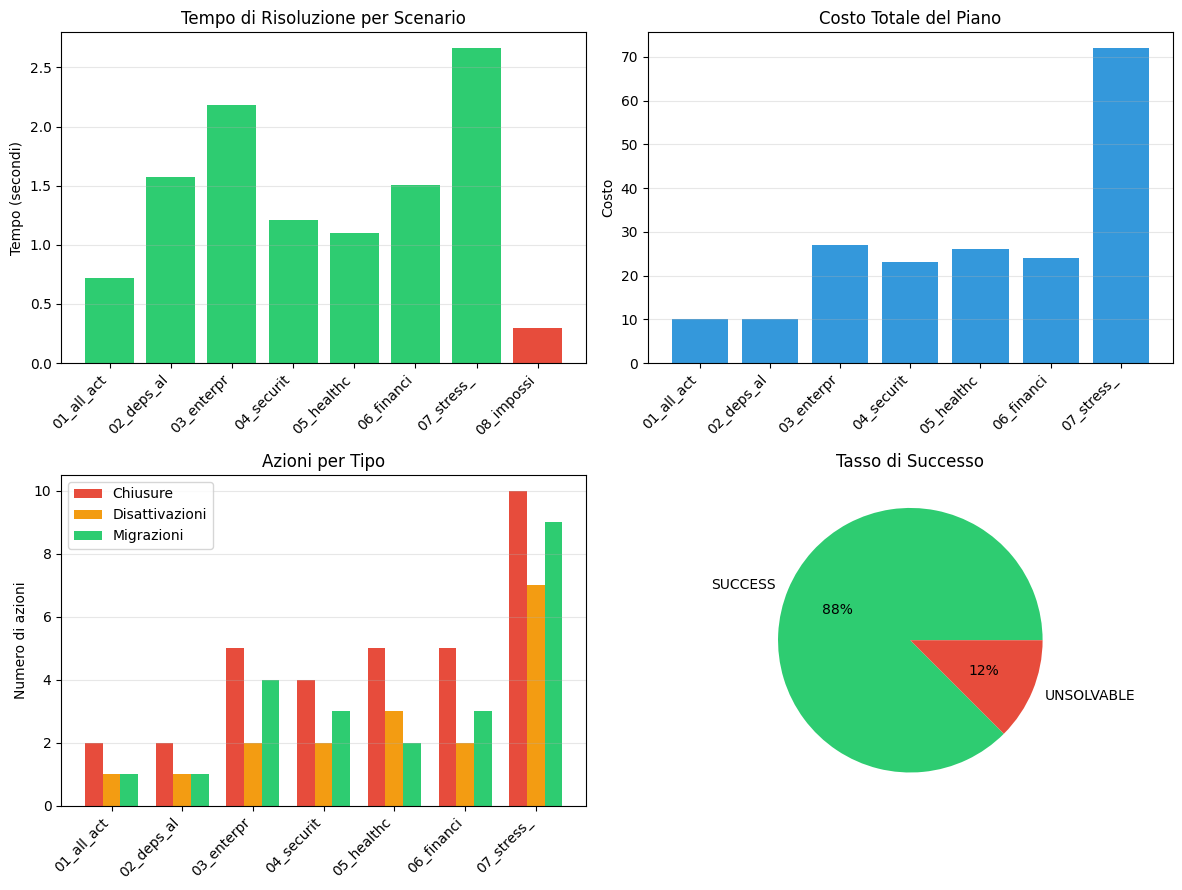


Grafico salvato in 'results/analysis.png'


In [14]:
# === CREAZIONE GRAFICI ===

# Filtra solo scenari risolti
df_ok = df_results[df_results['status'] == 'SUCCESS']

if len(df_ok) > 0:
    # Crea figura con 4 subplot (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))

    # --- GRAFICO 1: Tempo di risoluzione ---
    # Colore verde = risolto, rosso = non risolto
    colors = ['#2ecc71' if s == 'SUCCESS' else '#e74c3c' for s in df_results['status']]
    axes[0, 0].bar(range(len(df_results)), df_results['time'], color=colors)
    axes[0, 0].set_xticks(range(len(df_results)))
    axes[0, 0].set_xticklabels([s[:10] for s in df_results['scenario']], rotation=45, ha='right')
    axes[0, 0].set_ylabel('Tempo (secondi)')
    axes[0, 0].set_title('Tempo di Risoluzione per Scenario')
    axes[0, 0].grid(axis='y', alpha=0.3)

    # --- GRAFICO 2: Costo totale ---
    axes[0, 1].bar(range(len(df_ok)), df_ok['cost'], color='#3498db')
    axes[0, 1].set_xticks(range(len(df_ok)))
    axes[0, 1].set_xticklabels([s[:10] for s in df_ok['scenario']], rotation=45, ha='right')
    axes[0, 1].set_ylabel('Costo')
    axes[0, 1].set_title('Costo Totale del Piano')
    axes[0, 1].grid(axis='y', alpha=0.3)

    # --- GRAFICO 3: Azioni per tipo (bar chart raggruppato) ---
    x = range(len(df_ok))
    width = 0.25  # Larghezza delle barre

    # Tre barre affiancate per ogni scenario
    axes[1, 0].bar([i - width for i in x], df_ok['chiudi'], width,
                   label='Chiusure', color='#e74c3c')
    axes[1, 0].bar([i for i in x], df_ok['stop'], width,
                   label='Disattivazioni', color='#f39c12')
    axes[1, 0].bar([i + width for i in x], df_ok['migra'], width,
                   label='Migrazioni', color='#2ecc71')

    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([s[:10] for s in df_ok['scenario']], rotation=45, ha='right')
    axes[1, 0].set_ylabel('Numero di azioni')
    axes[1, 0].set_title('Azioni per Tipo')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)

    # --- GRAFICO 4: Tasso di successo (pie chart) ---
    counts = df_results['status'].value_counts()
    colors_pie = ['#2ecc71' if s == 'SUCCESS' else '#e74c3c' for s in counts.index]
    axes[1, 1].pie(counts.values, labels=counts.index, autopct='%1.0f%%', colors=colors_pie)
    axes[1, 1].set_title('Tasso di Successo')

    # Layout e salvataggio
    plt.tight_layout()
    plt.savefig('results/analysis.png', dpi=150)
    plt.show()

    print("\nGrafico salvato in 'results/analysis.png'")
else:
    print("Nessuno scenario risolto - impossibile generare grafici.")

---
## Note Tecniche

### Scelte Progettuali

1. **Tre azioni invece di cinque**: La versione iniziale includeva anche `riattiva_servizio` e separava le migrazioni per servizi critici/non critici. Queste sono state rimosse perché:
   - `riattiva_servizio` non veniva mai usata (nessun goal richiede servizi attivi)
   - Le due migrazioni avevano lo stesso effetto, differivano solo nel costo

2. **Porte senza alternativa**: SMTP (25), NetBIOS (139), SNMP (161) e TFTP (69) non hanno alternative configurate. Questo forza il planner a usare `disattiva_servizio` per questi casi.

3. **Dipendenze tra servizi**: Se un servizio A dipende da B, A non può essere attivo se B è inattivo. Il planner deve fermare prima i servizi dipendenti.

4. **Servizi critici**: Non possono essere disattivati. Se un servizio critico è su una porta vietata senza alternativa, lo scenario è irrisolvibile (vedi scenario 08).

### Limitazioni

- Il modello assume che le migrazioni siano atomiche (nessun downtime durante la migrazione)
- Non sono gestite finestre di manutenzione temporali
- Le dipendenze sono limitate allo stesso host (non cross-host)